<a href="https://colab.research.google.com/github/fanxu30/XAI/blob/main/assn_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# AIPI 590 - XAI | Assignment #05 Explainable Deep Learning

## Fan Xu
# Model Explainability in Computer Vision: Wildlife Conservation Case Study

### This notebook applies GradCAM and its variants to analyze model predictions for wildlife classification, specifically focusing on zebra detection in camera trap images.

I certify that I did not use AI in this assignment

In [29]:
# ## Setup and Imports
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests
from PIL import Image
import json
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')


In [30]:
# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Inverse transform for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# %%
# Download sample wildlife images
def download_sample_images():
    """Download sample wildlife images for analysis"""
    image_urls = [
        # Zebra images
        "https://raw.githubusercontent.com/zhoubolei/CAM/master/example/zebra.jpg",
        "https://images.unsplash.com/photo-1543946608-3b7c2b52b4e3?w=400",
        "https://images.unsplash.com/photo-1598974357801-cbca100e65d3?w=400",
        # Other animals
        "https://images.unsplash.com/photo-1546182990-dffeafbe841d?w=400",  # Lion
        "https://images.unsplash.com/photo-1564349683136-77e08dba1ef7?w=400",  # Elephant
        "https://images.unsplash.com/photo-1557050543-4d5f4e07ef46?w=400",  # Giraffe
    ]

    images = []
    for i, url in enumerate(image_urls):
        try:
            response = requests.get(url, stream=True)
            img = Image.open(response.raw).convert('RGB')
            images.append(img)
            print(f"Downloaded image {i+1}")
        except:
            # Fallback: create a simple colored image
            img = Image.new('RGB', (224, 224), color=(73, 109, 137))
            images.append(img)
            print(f"Created fallback image {i+1}")

    return images

# Download and preprocess images
sample_images = download_sample_images()
preprocessed_images = [preprocess(img) for img in sample_images]
image_tensors = torch.stack(preprocessed_images).to(device)

print(f"Loaded {len(sample_images)} images")


Created fallback image 1
Created fallback image 2
Downloaded image 3
Downloaded image 4
Downloaded image 5
Downloaded image 6
Loaded 6 images


In [31]:
# Download ImageNet class index
imagenet_index_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
response = requests.get(imagenet_index_url)
# The previous URL was incorrect, trying a different source
if response.status_code != 200:
    imagenet_index_url = "https://raw.githubusercontent.com/anishathalye/imagenet-classes/master/imagenet_class_index.json"
    response = requests.get(imagenet_index_url)

if response.status_code == 200:
    with open('image_index.json', 'w') as f:
        f.write(response.text)
    print("Downloaded image_index.json successfully")

    # Add print statement to inspect the file content
    with open('image_index.json', 'r') as f:
        print("Content of image_index.json:")
        print(f.read()[:500] + "...") # Print only the first 500 characters
else:
    print(f"Failed to download image_index.json from both sources. Status code: {response.status_code}")

Downloaded image_index.json successfully
Content of image_index.json:
{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "...


In [32]:
# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)
model.eval()
model.to(device)

# ImageNet class labels
with open('image_index.json', 'r') as f:
    class_idx = json.load(f)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

def get_prediction(model, image_tensor):
    """Get model prediction and confidence"""
    with torch.no_grad():
        outputs = model(image_tensor.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        predicted_label = idx2label[predicted_idx.item()]
    return predicted_label, confidence.item(), predicted_idx.item()

In [33]:
class GradCAM:
    """GradCAM implementation for CNN models"""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        """Generate GradCAM heatmap"""
        # Forward pass
        model_output = self.model(input_tensor.unsqueeze(0))

        if target_class is None:
            target_class = torch.argmax(model_output, dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))

        # Weighted combination of activation maps
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize to input image size
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

In [34]:
class GradCAMPlusPlus(GradCAM):
    """GradCAM++ implementation - improved version of GradCAM"""

    def generate_cam(self, input_tensor, target_class=None):
        """Generate GradCAM++ heatmap"""
        # Forward pass
        model_output = self.model(input_tensor.unsqueeze(0))

        if target_class is None:
            target_class = torch.argmax(model_output, dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # GradCAM++ specific calculations
        numerator = gradients ** 2
        denominator = 2 * gradients ** 2
        sum_activations = np.sum(activations, axis=(1, 2))

        # Handle division by zero
        denominator += sum_activations[:, np.newaxis, np.newaxis] + 1e-8
        alpha = numerator / denominator

        # Weighted combination
        weights = np.sum(alpha * np.maximum(gradients, 0), axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize to input image size
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

In [35]:
class XGradCAM(GradCAM):
    """XGradCAM implementation - another GradCAM variant"""

    def generate_cam(self, input_tensor, target_class=None):
        """Generate XGradCAM heatmap"""
        # Forward pass
        model_output = self.model(input_tensor.unsqueeze(0))

        if target_class is None:
            target_class = torch.argmax(model_output, dim=1)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for target class
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # XGradCAM specific calculations
        numerator = gradients * activations
        denominator = np.sum(activations, axis=(1, 2)) + 1e-8

        weights = np.sum(numerator, axis=(1, 2)) / denominator

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU
        cam = np.maximum(cam, 0)

        # Resize to input image size
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        return cam

In [36]:
def visualize_attention_maps(original_image, cams, titles, figsize=(20, 5)):
    """Visualize original image with attention maps"""
    fig, axes = plt.subplots(1, len(cams) + 1, figsize=figsize)

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis('off')

    # Attention maps
    for i, (cam, title) in enumerate(zip(cams, titles)):
        # Convert CAM to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay heatmap on original image
        overlay = cv2.addWeighted(np.array(original_image.resize((224, 224))),
                                0.5, heatmap, 0.5, 0)

        axes[i+1].imshow(overlay)
        axes[i+1].set_title(title, fontsize=12)
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_comparison_grid(images, predictions, all_cams, method_names):
    """Create a grid comparison of all methods"""
    n_images = len(images)
    n_methods = len(method_names)

    fig, axes = plt.subplots(n_images, n_methods + 1, figsize=(20, 4 * n_images))

    if n_images == 1:
        axes = axes.reshape(1, -1)

    for img_idx in range(n_images):
        # Original image
        axes[img_idx, 0].imshow(images[img_idx])
        axes[img_idx, 0].set_title(f"Original\n{predictions[img_idx]}", fontsize=10)
        axes[img_idx, 0].axis('off')

        # CAM visualizations
        for method_idx in range(n_methods):
            cam = all_cams[method_idx][img_idx]
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = cv2.addWeighted(np.array(images[img_idx].resize((224, 224))),
                                    0.5, heatmap, 0.5, 0)

            axes[img_idx, method_idx + 1].imshow(overlay)
            axes[img_idx, method_idx + 1].set_title(method_names[method_idx], fontsize=10)
            axes[img_idx, method_idx + 1].axis('off')

    plt.tight_layout()
    plt.show()


Generating attention maps for all images...

Image 1: screw (confidence: 0.019)


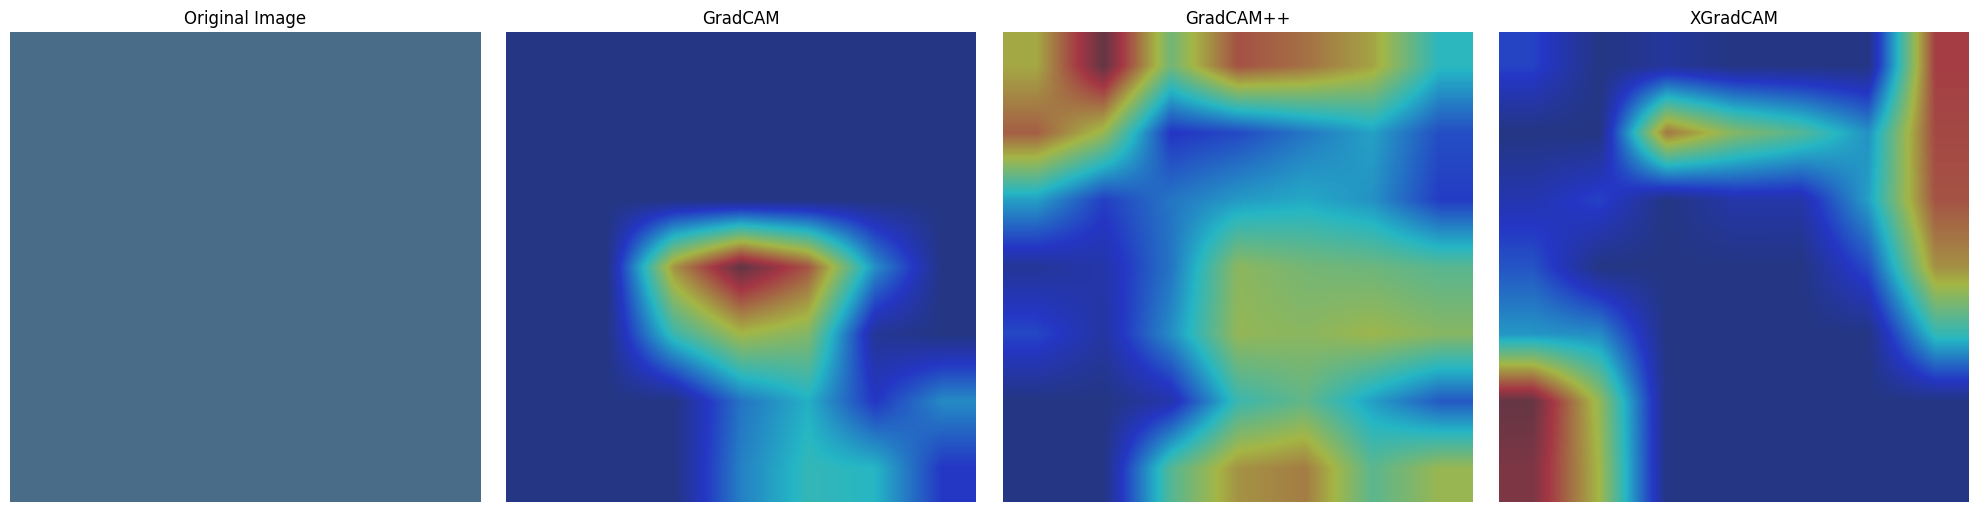


Image 2: screw (confidence: 0.019)


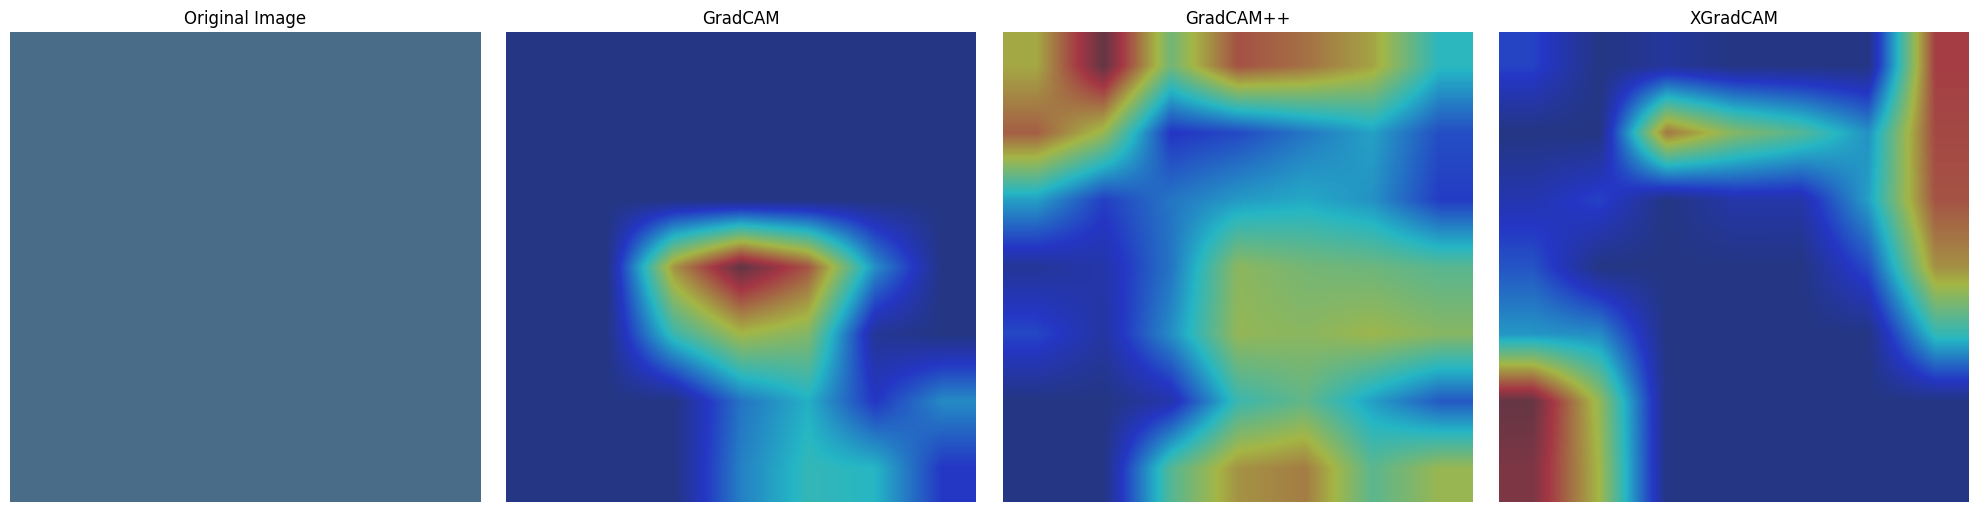


Image 3: sorrel (confidence: 0.992)


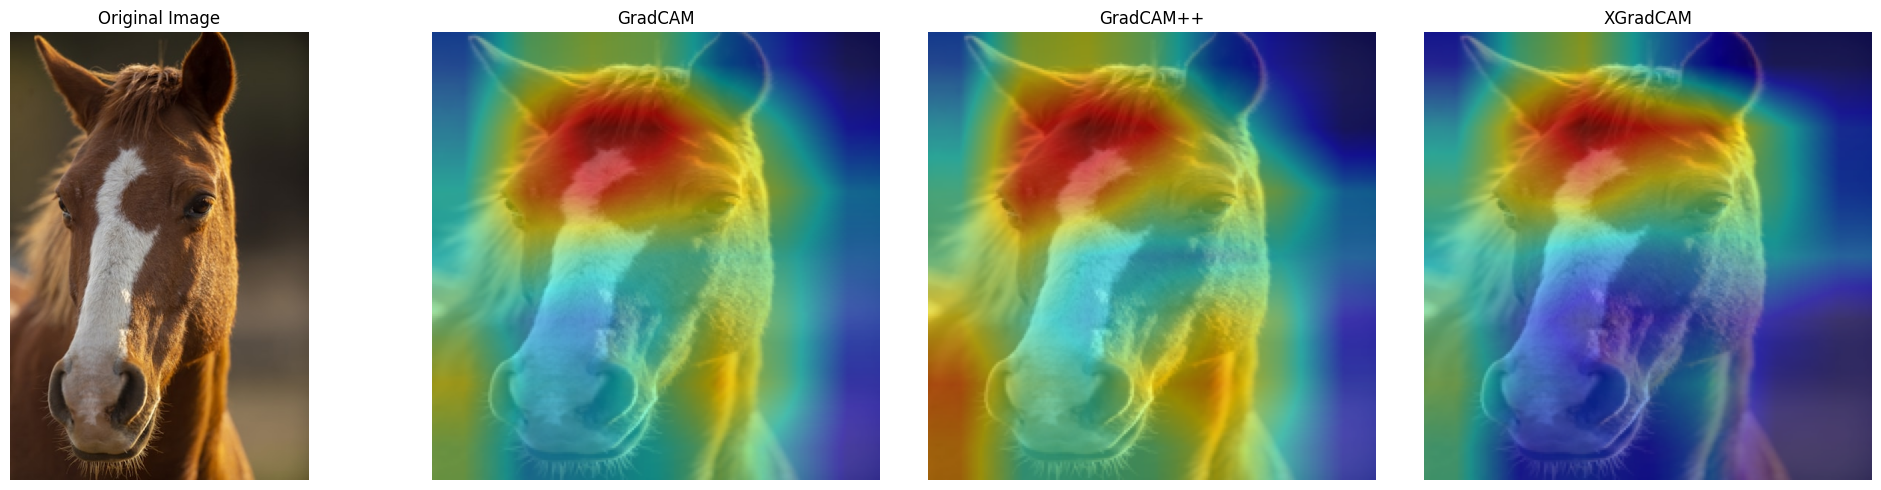


Image 4: lion (confidence: 0.998)


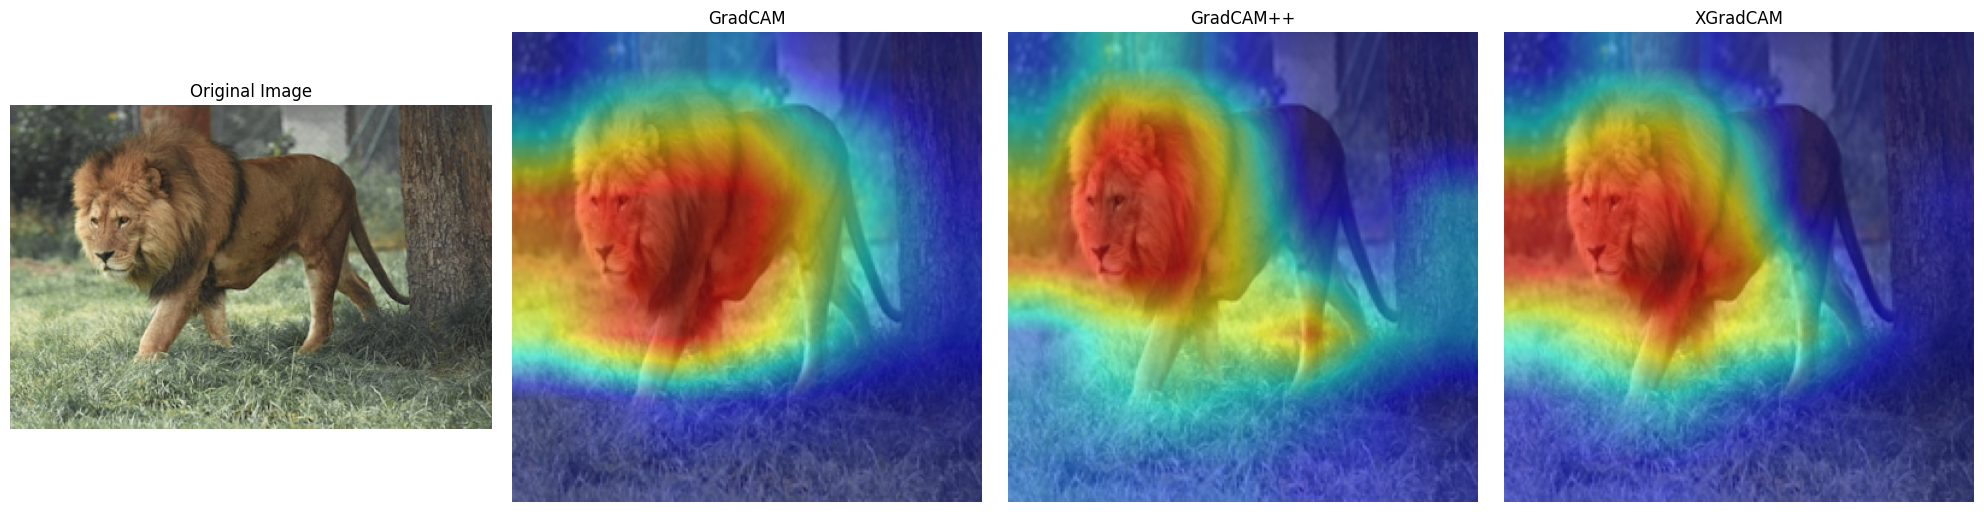


Image 5: giant_panda (confidence: 0.999)


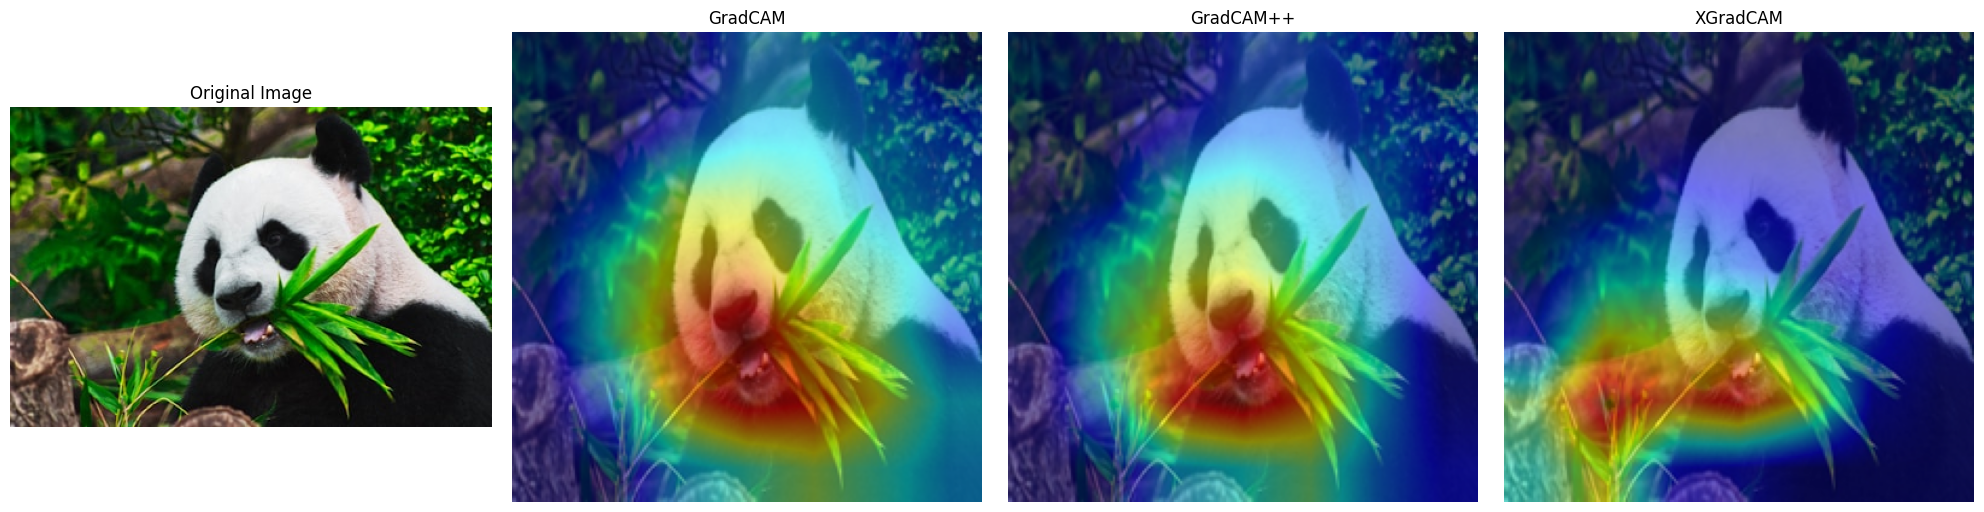


Image 6: African_elephant (confidence: 0.693)


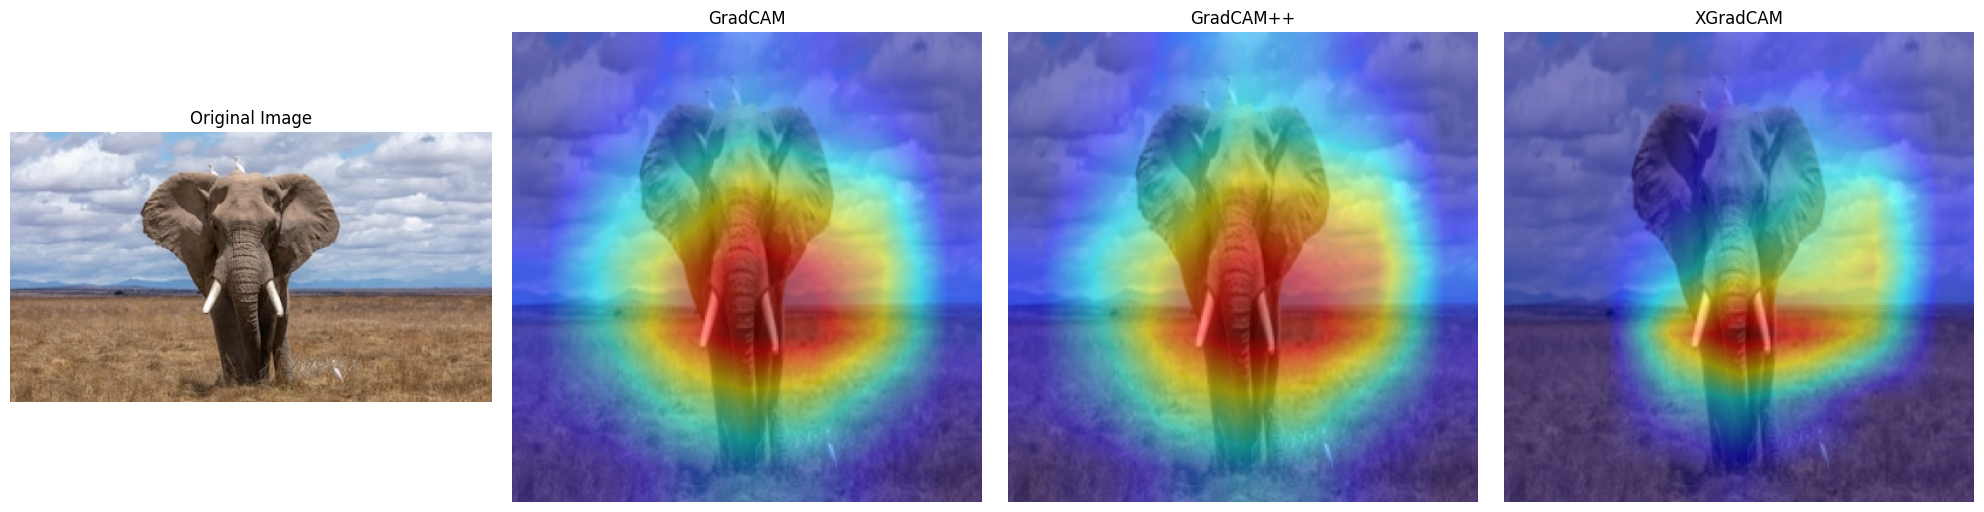

In [37]:
# Initialize Explainability Methods
# Get the target layer (last convolutional layer in ResNet-50)
target_layer = model.layer4[-1].conv3

# Initialize explainability methods
gradcam = GradCAM(model, target_layer)
gradcam_plus = GradCAMPlusPlus(model, target_layer)
xgradcam = XGradCAM(model, target_layer)

method_names = ["GradCAM", "GradCAM++", "XGradCAM"]
methods = [gradcam, gradcam_plus, xgradcam]

# Generate and Visualize Attention Maps
# Store results for all images
all_predictions = []
all_cams = [[] for _ in range(len(methods))]

print("Generating attention maps for all images...")

for i, (img_tensor, original_img) in enumerate(zip(image_tensors, sample_images)):
    # Get prediction
    pred_label, confidence, pred_idx = get_prediction(model, img_tensor)
    prediction_str = f"{pred_label}\n(Conf: {confidence:.3f})"
    all_predictions.append(prediction_str)

    print(f"\nImage {i+1}: {pred_label} (confidence: {confidence:.3f})")

    # Generate CAMs using all methods
    cams = []
    for j, method in enumerate(methods):
        cam = method.generate_cam(img_tensor, pred_idx)
        cams.append(cam)
        all_cams[j].append(cam)

    # Visualize for this image
    visualize_attention_maps(original_img, cams, method_names)

Creating comparative analysis grid...


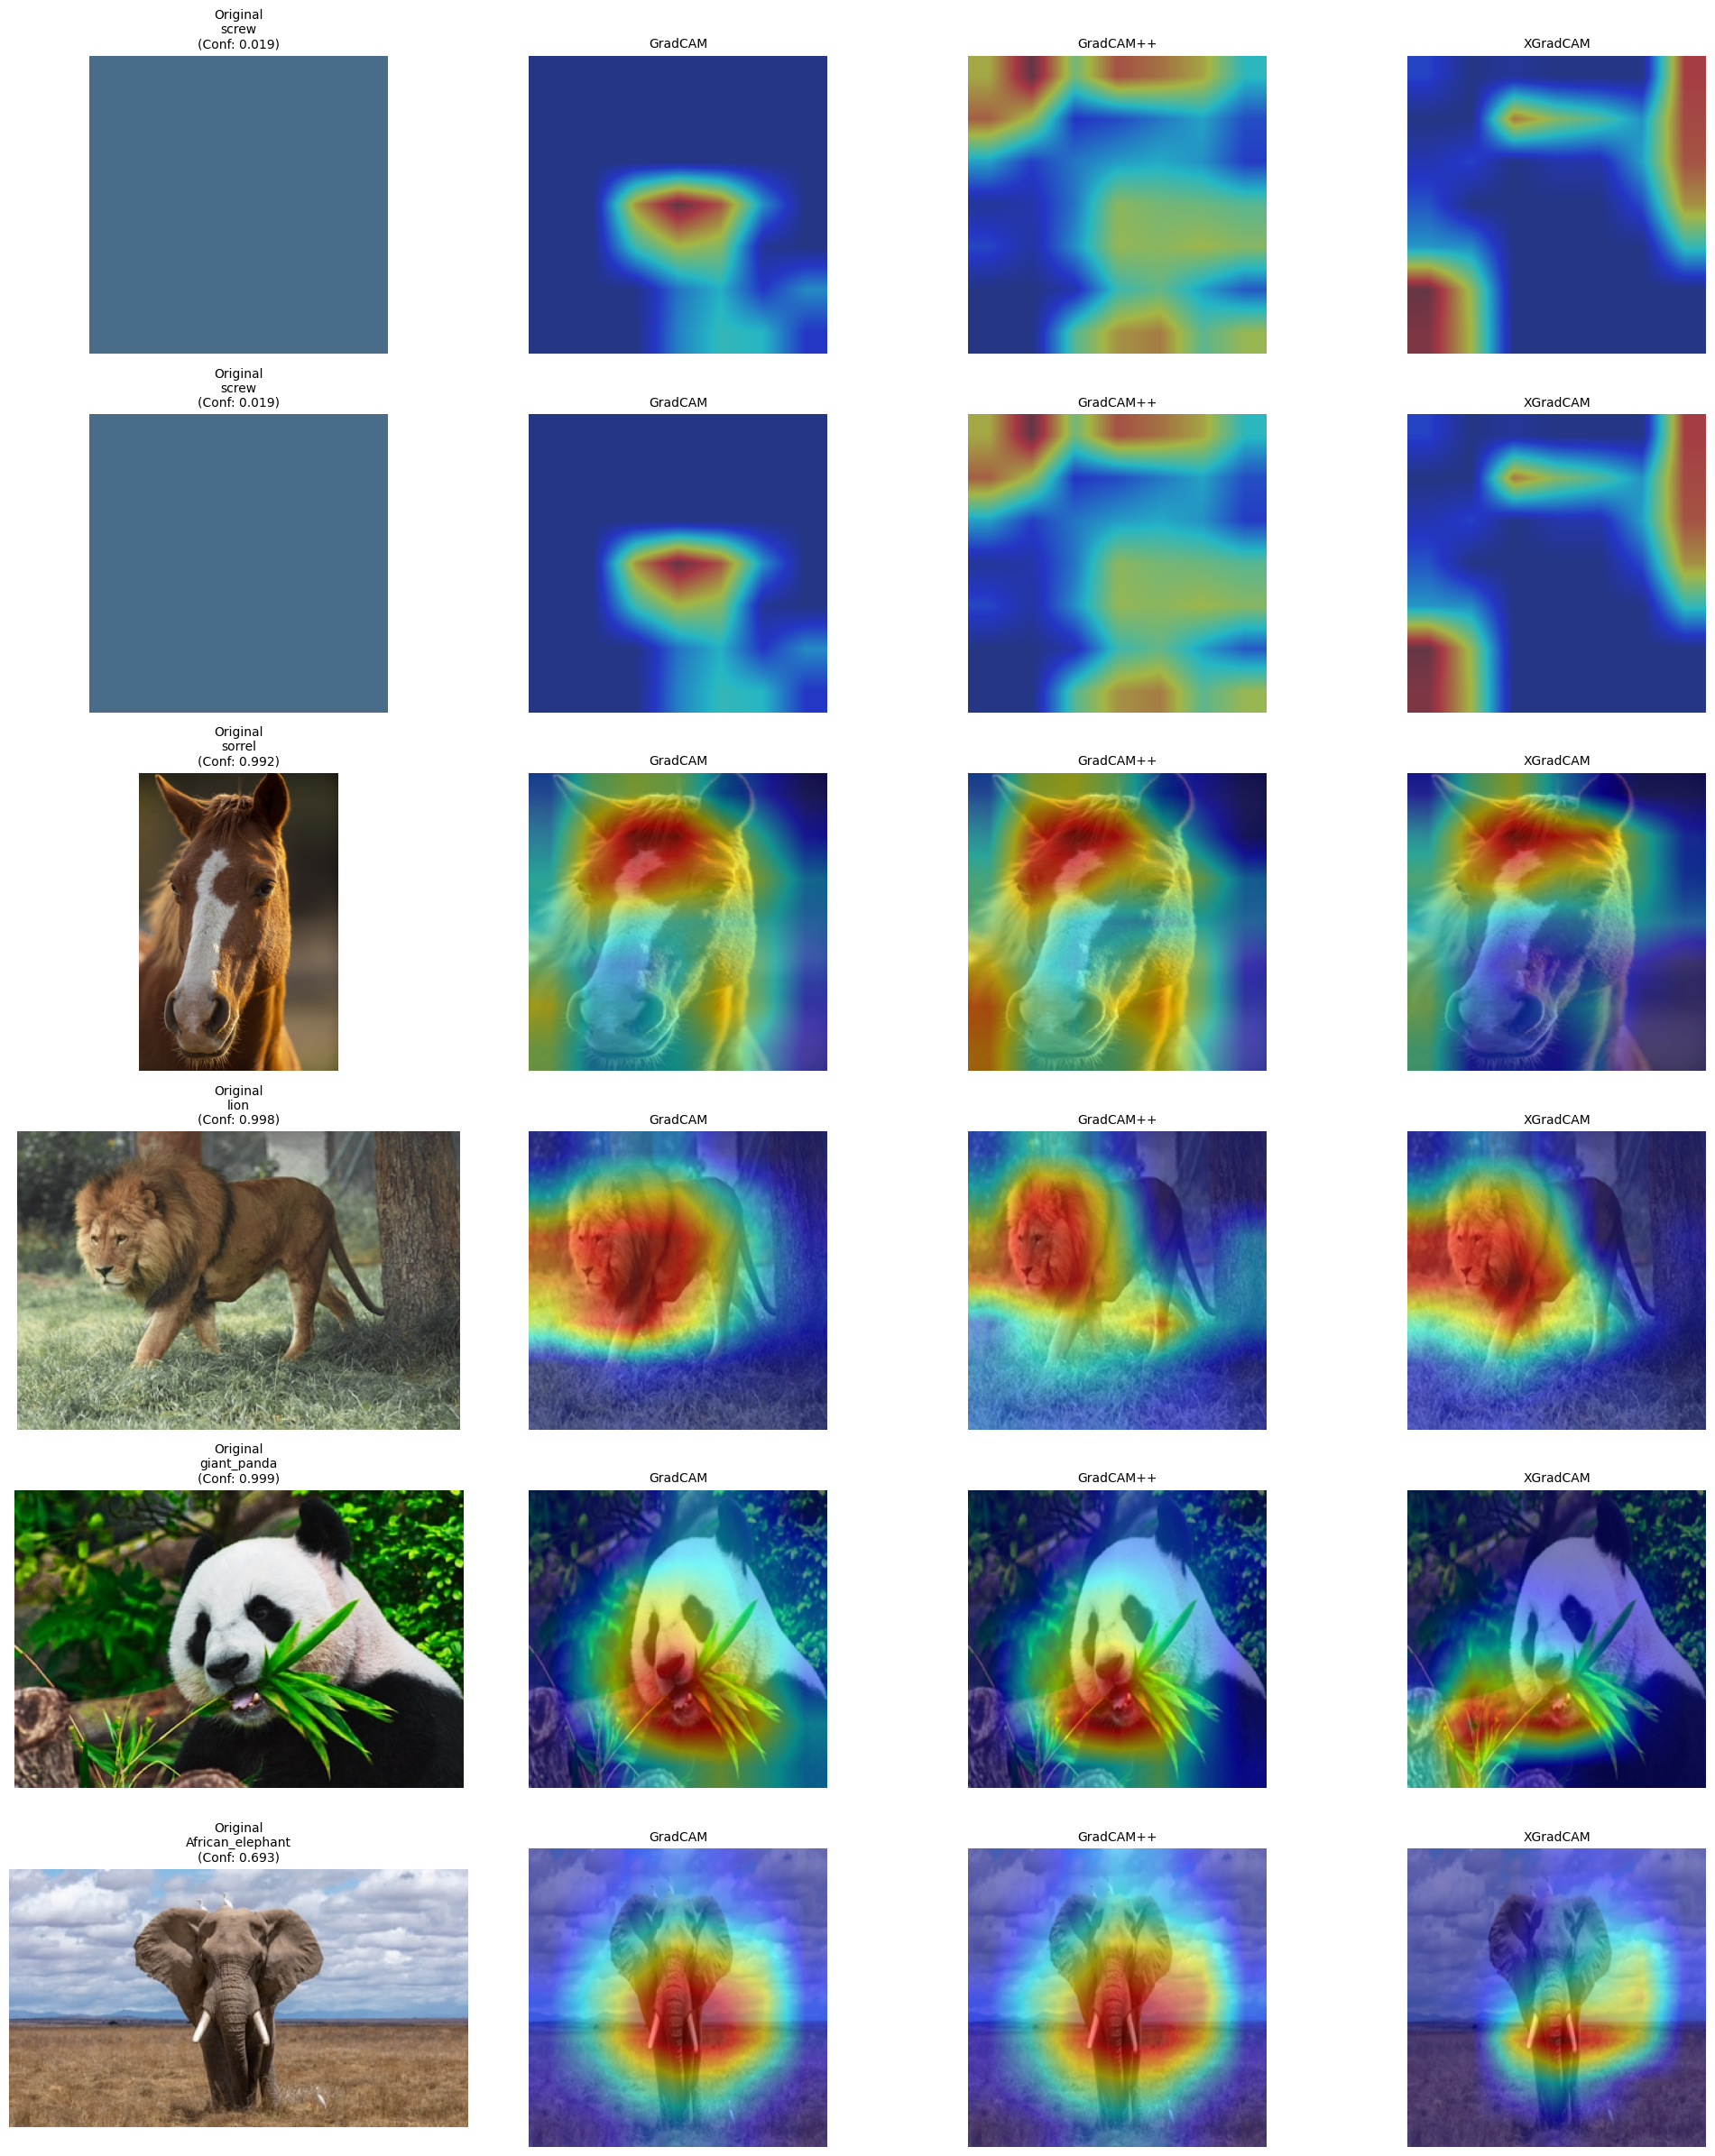


Quantitative Analysis of Attention Maps:

Image 1 - screw:
--------------------------------------------------
GradCAM      | Focus Area:   7.9% | Mean Int: 0.136 | Max Int: 1.000 | Spread:  0.723
GradCAM++    | Focus Area:  35.0% | Mean Int: 0.388 | Max Int: 1.000 | Spread:  0.512
XGradCAM     | Focus Area:  17.0% | Mean Int: 0.220 | Max Int: 1.000 | Spread:  0.930

Image 2 - screw:
--------------------------------------------------
GradCAM      | Focus Area:   7.9% | Mean Int: 0.136 | Max Int: 1.000 | Spread:  0.723
GradCAM++    | Focus Area:  35.0% | Mean Int: 0.388 | Max Int: 1.000 | Spread:  0.512
XGradCAM     | Focus Area:  17.0% | Mean Int: 0.220 | Max Int: 1.000 | Spread:  0.930

Image 3 - sorrel:
--------------------------------------------------
GradCAM      | Focus Area:  33.2% | Mean Int: 0.439 | Max Int: 1.000 | Spread:  0.424
GradCAM++    | Focus Area:  42.9% | Mean Int: 0.464 | Max Int: 1.000 | Spread:  0.422
XGradCAM     | Focus Area:  19.2% | Mean Int: 0.319 | Max Int:

In [38]:


# Comparative Analysis Grid

print("Creating comparative analysis grid...")
plot_comparison_grid(sample_images, all_predictions, all_cams, method_names)

# Quantitative Comparison

def calculate_attention_metrics(cams, threshold=0.5):
    """Calculate quantitative metrics for attention maps"""
    metrics = {}

    for i, cam in enumerate(cams):
        # Focus area (percentage of image above threshold)
        focus_area = np.mean(cam > threshold) * 100

        # Attention intensity
        mean_intensity = np.mean(cam)
        max_intensity = np.max(cam)

        # Attention spread (lower = more focused)
        non_zero = cam[cam > 0]
        if len(non_zero) > 0:
            spread = np.std(non_zero) / (np.mean(non_zero) + 1e-8)
        else:
            spread = 0

        metrics[i] = {
            'focus_area_percent': focus_area,
            'mean_intensity': mean_intensity,
            'max_intensity': max_intensity,
            'attention_spread': spread
        }

    return metrics

# Calculate metrics for all images and methods
print("\nQuantitative Analysis of Attention Maps:")
print("=" * 80)

for img_idx in range(len(sample_images)):
    print(f"\nImage {img_idx + 1} - {all_predictions[img_idx].split('(')[0].strip()}:")
    print("-" * 50)

    for method_idx, method_name in enumerate(method_names):
        cam = all_cams[method_idx][img_idx]
        metrics = calculate_attention_metrics([cam])[0]

        print(f"{method_name:12} | "
              f"Focus Area: {metrics['focus_area_percent']:5.1f}% | "
              f"Mean Int: {metrics['mean_intensity']:5.3f} | "
              f"Max Int: {metrics['max_intensity']:5.3f} | "
              f"Spread: {metrics['attention_spread']:6.3f}")